### Convolutional Auto-encoders

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image

In [2]:
#the usual imports
import lasagne
import theano
import lasagne.layers as layer
import lasagne.layers.cuda_convnet as layerc
import theano.tensor as T

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN 4007)


In [3]:
#just a helper to load data!!
from helpers import load_dataset

In [4]:
print("Loading data...")
X_train, _, X_val, _, X_test, _ = load_dataset()
print("Data loaded...")

Loading data...
Data loaded...


### Types of padding

In [34]:
random_image = X_train[0:1]
random_image.shape

(1, 1, 28, 28)

In [35]:
dummy_input = layer.InputLayer(shape=(1,1,28,28))

valid = layer.Conv2DLayer(dummy_input, W = lasagne.init.np.ones((1,1,3,3), dtype=np.float32),
                            num_filters=1,filter_size=3, 
                            pad="valid")

full = layer.Conv2DLayer(dummy_input, W = lasagne.init.np.ones((1,1,3,3),dtype=np.float32),
                            num_filters=1,filter_size=3, 
                            pad="full")

same = layer.Conv2DLayer(dummy_input, W = lasagne.init.np.ones((1,1,3,3),dtype=np.float32),
                            num_filters=1,filter_size=3, 
                            pad="same")

valid_l, full_l, same_l = lasagne.layers.get_output([valid,full,same])

paddings = theano.function(inputs=[dummy_input.input_var],
                outputs=[valid_l,full_l,same_l])

valid_image , full_image , same_image = paddings(random_image)

print "valid image:", valid_image.shape, "\nfull image:", full_image.shape, "\nsame_image:", same_image.shape

valid image: (1, 1, 26, 26) 
full image: (1, 1, 30, 30) 
same_image: (1, 1, 28, 28)


### How full and valid padddings can be used interestingly!

In [24]:
def convolutional_autoencoder(input_var=None):
    
    network = layer.InputLayer(shape=(None,1,28,28),
                               input_var=input_var, name = "input")
    
    network = layerc.Conv2DCCLayer(network, 
                                   num_filters=16, 
                                   filter_size=3, 
                                   pad="valid", name = "conv1")
    
    network = layerc.Conv2DCCLayer(network, 
                                   num_filters=16, 
                                   filter_size=3,
                                   pad="valid", name = "conv2")
    
    network = layerc.MaxPool2DCCLayer(network,
                                      (2,2), name = "maxpool1")
    
    network = layerc.Conv2DCCLayer(network, 
                                   num_filters=32,
                                   filter_size=3, 
                                   pad="valid", name = "conv3")
    
    network = layerc.MaxPool2DCCLayer(network,
                                      (2,2), name = "maxpool2")
    
    network = layer.reshape(network,([0],-1), name = "flatten")
    
    network = layer.DenseLayer(network, num_units=128, name = "dense1")
    network = layer.DenseLayer(network, num_units=16, name = "dense2")
    network = layer.DenseLayer(network, num_units=128, name = "dense-2")
    network = layer.DenseLayer(network, num_units=800, name = "dense-1")
    
    network = layer.reshape(network,(-1,32,5,5), name = "unflatten")
    
    network = layer.Upscale2DLayer(network,
                                   scale_factor=2, name = "upscale-2")
    
    network = layerc.Conv2DCCLayer(network, 
                                   num_filters=16,
                                   filter_size=3,
                                   pad="full", name = "deconv-3")
    
    network = layer.Upscale2DLayer(network,
                                   scale_factor=2, name = "upscale-2")
    
    network = layerc.Conv2DCCLayer(network, 
                                   num_filters=16,
                                   filter_size=3,
                                   pad="full", name = "deconv-2")
    
    network = layer.Conv2DLayer(network, 
                                num_filters=1,
                                filter_size=3,
                                pad="full", name = "deconv-1")
    
    return network

In [7]:
ip = T.tensor4("input")

In [25]:
network = convolutional_autoencoder(ip)

In [27]:
#let' see what we got!!
for l in lasagne.layers.get_all_layers(network):
    print l.name, l.output_shape

input (None, 1, 28, 28)
conv1 (None, 16, 26, 26)
conv2 (None, 16, 24, 24)
maxpool1 (None, 16, 12, 12)
conv3 (None, 32, 10, 10)
maxpool2 (None, 32, 5, 5)
flatten (None, 800)
dense1 (None, 128)
dense2 (None, 16)
dense-2 (None, 128)
dense-1 (None, 800)
unflatten (None, 32, 5, 5)
upscale-2 (None, 32, 10, 10)
deconv-3 (None, 16, 12, 12)
upscale-2 (None, 16, 24, 24)
deconv-2 (None, 16, 26, 26)
deconv-1 (None, 1, 28, 28)


In [10]:
#get output of network
prediction = lasagne.layers.get_output(network)

#define loss
loss = lasagne.objectives.squared_error(ip,prediction)
loss = loss.mean()

#gete network parameters
params = lasagne.layers.get_all_params(network, trainable=True)

#define backprop
updates = lasagne.updates.adam(loss,params)                                

In [28]:
#the usual functions
train_fn = theano.function(inputs = [ip], 
                           outputs = loss, #interested in loss
                           updates = updates)

test_fn = theano.function(inputs = [ip], 
                          outputs = prediction) #interested in actual output
                            #also no updates!!

In [14]:
num_epochs = 10
batch_size = 100
for epoch in range(num_epochs):
    train_loss = []
    for i in range(0,X_train.shape[0]- batch_size, batch_size):
        train_loss.append(train_fn(X_train[i:i+batch_size]))
    print "after epoch", epoch+1, "training loss: " , np.mean(train_loss)

after epoch 1 training loss:  0.0155701
after epoch 2 training loss:  0.0149746
after epoch 3 training loss:  0.0145273
after epoch 4 training loss:  0.0141264
after epoch 5 training loss:  0.0137614
after epoch 6 training loss:  0.0134416
after epoch 7 training loss:  0.0131674
after epoch 8 training loss:  0.0129334
after epoch 9 training loss:  0.0127275
after epoch 10 training loss:  0.0125456


In [20]:
output_image = test_fn(X_test[1:2])

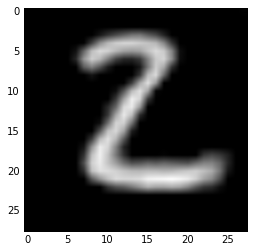

In [21]:
#let's see what network got!!
plt.imshow(output_image.reshape((28,28)), cmap="gray")

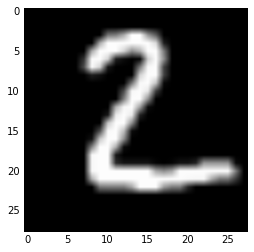

In [22]:
#what it actually was!!
plt.imshow(X_test[1:2].reshape((28,28)), cmap="gray")